### Import Packages

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import randint
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV )
from sklearn.metrics import r2_score

### Global Variables

In [2]:
YEAR = 5
AUTOMODE = True

train_file_path = f'../data_processing/Unfiltered-Data/Train/train-data-{YEAR}-year.csv'
test_file_path = f'../data_processing/Unfiltered-Data/Test/test-data-{YEAR}-year.csv'
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

X_training, Y_training, X_testing, Y_testing = [], [], [], []
imputer = SimpleImputer(strategy='mean')   # deal with missing area

# the points for performing diagram
plt_r2train = []
plt_r2test = []
plt_n = []
cv_results = []

Regressor = None

# best result for 5 years
rf_parameters = {
    'n_estimators': 200,
    'criterion': 'friedman_mse',
    'max_depth': 18,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'random_state': 165,
    'n_jobs': -1
}
params_grid = {
    'n_estimators': 120,
    'criterion': 'friedman_mse',
    'max_depth': 18,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'auto',
    'random_state': 100,
    'n_jobs': -1
}


### Training and Testing Dataset

In [3]:
def DataPreprocessing(train_df, test_df):
    # Prepocess data frame, convert all elements to int/float type, deal with NaN value in area column.
    train_df = train_df.apply(pd.to_numeric, errors='coerce')
    train_df['area'] = imputer.fit_transform(train_df[['area']])

    features_train = train_df.drop('price', axis='columns')
    label_train = train_df['price']
    
    features_test = test_df.drop('price', axis='columns')
    label_test = test_df['price']

    return features_train, label_train, features_test, label_test

X_training, Y_training, X_testing, Y_testing = DataPreprocessing(train_df, test_df)
print(X_training.shape)
print(Y_training.shape)
print(X_testing.shape)
print(Y_testing.shape)
# print(X_training[0:3])
# print(Y_training[0:3])

(25533, 24)
(25533,)
(2837, 24)
(2837,)


### Random Forest

In [4]:
def RandomForest(n_estimators, param):
    regressor = RandomForestRegressor(
        n_estimators=n_estimators,
        min_samples_split=param['min_samples_split'],
        min_samples_leaf=param['min_samples_leaf'],
        n_jobs=-1
    )
    print('[OK] Build Regressor')
    regressor.fit(X_training, Y_training)
    
    return regressor

### Make Predictions

In [5]:
def MakePredictions(X, regressor):
    return regressor.predict(X)

### Randomized Cross Validation

In [6]:
def AutoTuningRandomized(X_training, Y_training):
    param = {
        'n_estimators': randint(100, 200),
        'max_depth': randint(10, 20),
        'min_samples_split': randint(2, 5),
        'min_samples_leaf': randint(1, 4),
        'random_state': randint(100, 200),
    }

    # automatically search for best parameters and the corresponding score
    result = RandomizedSearchCV (
        RandomForestRegressor(),
        param_distributions=param,
        scoring='r2',
        verbose=4,
        cv=3,
        n_iter=3
    )

    result.fit(X_training, Y_training)
    best_param = result.best_params_
    best_score = result.best_score_
    print(f'Best param in rCV: {best_param}')
    print(f'Best score in rCV: {round(best_score * 100, 3)}')

    return best_param

### Grid Cross Validation

In [7]:
def AutoTuningGrid(X_training, Y_training):
    global Regressor

    num_trees = list(range(1, 41, 2))
    params = {
        'min_samples_split': list(range(1, 5, 1)),
        'min_samples_leaf': list(range(1, 5, 1))
    }
    best_param = {
        'min_samples_split': 2,
        'min_samples_leaf': 1
    }

    max_score = -999
    for n in num_trees:
        for name, value in params.items():
            param_single = {name: value}

            result = GridSearchCV (
                RandomForestRegressor(n_estimators=n),
                param_grid=param_single,
                scoring='r2',
                verbose=4,
                cv=3
            )

        result.fit(X_training, Y_training)

        best_param[name] = result.best_params_[name]
        best_score = result.best_score_
        print(f'Current params: {best_param}')
        print(f'Current {name} score: {round(best_score * 100, 3)} %')

        # make predictions w/ current params
        regressor = RandomForest(n, best_param)
        predictions = MakePredictions(X_training, regressor)
        r2_train = r2_score(Y_training, predictions)
        predictions = MakePredictions(X_testing, regressor)
        r2_test = r2_score(Y_testing, predictions)
        print(f'| Number of trees: {n}')
        print(f'| R2 training: {round(r2_train * 100, 3)} %')
        print(f'| R2 testing: {round(r2_test * 100, 3)} %')

        # update regressor and max score
        if r2_train > max_score:
            Regressor = regressor
            max_score = r2_train

        # append the current points for diagram
        plt_r2train.append(r2_train)
        plt_r2test.append(r2_test)
        plt_n.append(n)

        # append current results for diagram
        cv_results.append({
            'param_name': name,
            'param_values': value,
            'best_param': result.best_params_[name],
            'best_score': result.best_score_,
            'cv_results': result.cv_results_
        })

    return best_param


params_grid = AutoTuningGrid(X_training, Y_training)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ................min_samples_leaf=1;, score=0.741 total time=   0.1s
[CV 2/3] END ................min_samples_leaf=1;, score=0.739 total time=   0.1s
[CV 3/3] END ................min_samples_leaf=1;, score=0.748 total time=   0.1s
[CV 1/3] END ................min_samples_leaf=2;, score=0.763 total time=   0.0s
[CV 2/3] END ................min_samples_leaf=2;, score=0.755 total time=   0.0s
[CV 3/3] END ................min_samples_leaf=2;, score=0.774 total time=   0.0s
[CV 1/3] END ................min_samples_leaf=3;, score=0.785 total time=   0.0s
[CV 2/3] END ................min_samples_leaf=3;, score=0.762 total time=   0.0s
[CV 3/3] END ................min_samples_leaf=3;, score=0.787 total time=   0.0s
[CV 1/3] END ................min_samples_leaf=4;, score=0.787 total time=   0.0s
[CV 2/3] END ................min_samples_leaf=4;, score=0.766 total time=   0.0s
[CV 3/3] END ................min_samples_leaf=4;,

### Final Predictions

In [8]:
predictions = MakePredictions(X_training, Regressor)
r2 = r2_score(Y_training, predictions)
print(f'R2 training: {round(r2 * 100, 3)} %')

predictions = MakePredictions(X_testing, Regressor)
r2 = r2_score(Y_testing, predictions)
print(f'R2 testing: {round(r2 * 100, 3)} %')

R2 training: 98.055 %
R2 testing: 89.017 %


### CV Results Diagram

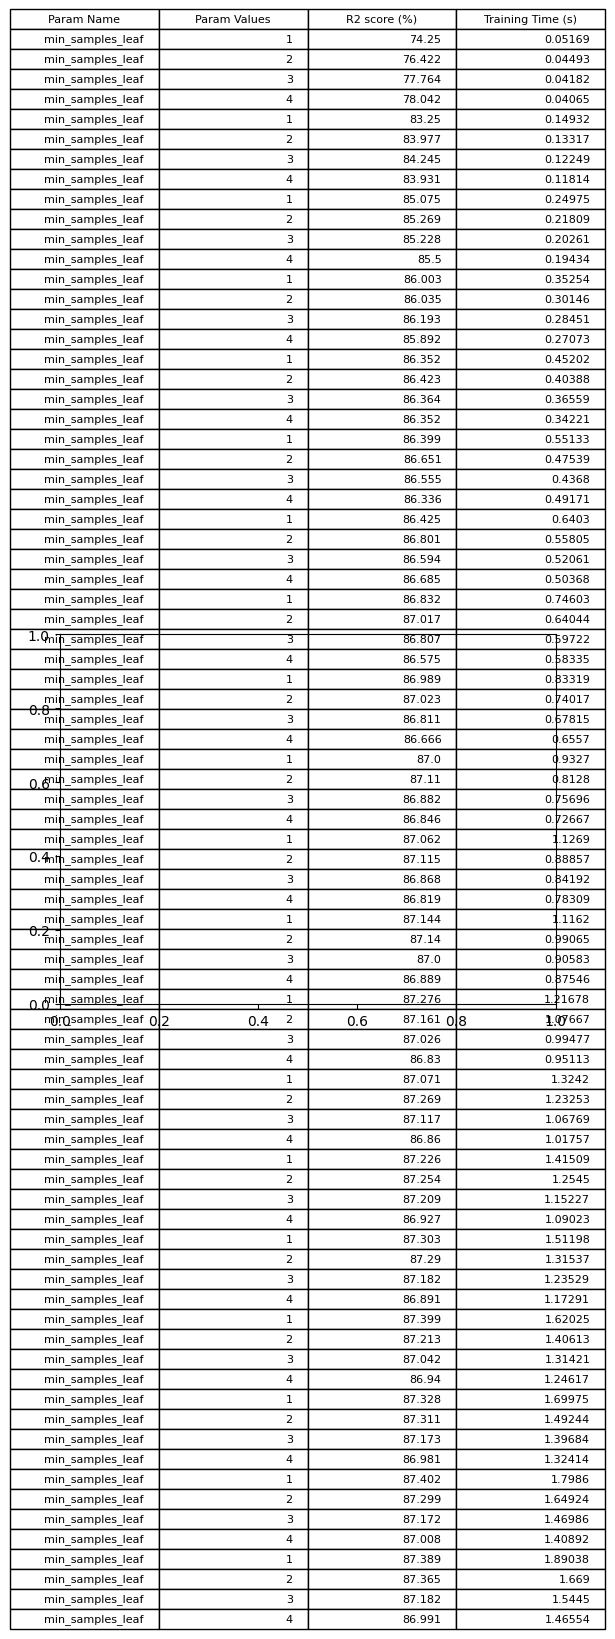

In [9]:
def ShowCVResults():
    _, axis = plt.subplots()
    headers = ['Param Name', 'Param Values', 'R2 score (%)', 'Training Time (s)']
    data = []

    for result in cv_results:
        name = result['param_name']
        values = result['param_values']
        scores = result['cv_results']['mean_test_score']   # r2
        times = result['cv_results']['mean_fit_time']   # training time

        for value, score, time in zip(values, scores, times):
            data.append([name, value, round(score * 100, 3), round(time, 5)])

    table = axis.table(cellText=data, colLabels=headers, loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.2, 1.2)
    plt.show()


ShowCVResults()


### R2 scores vs. N Diagram

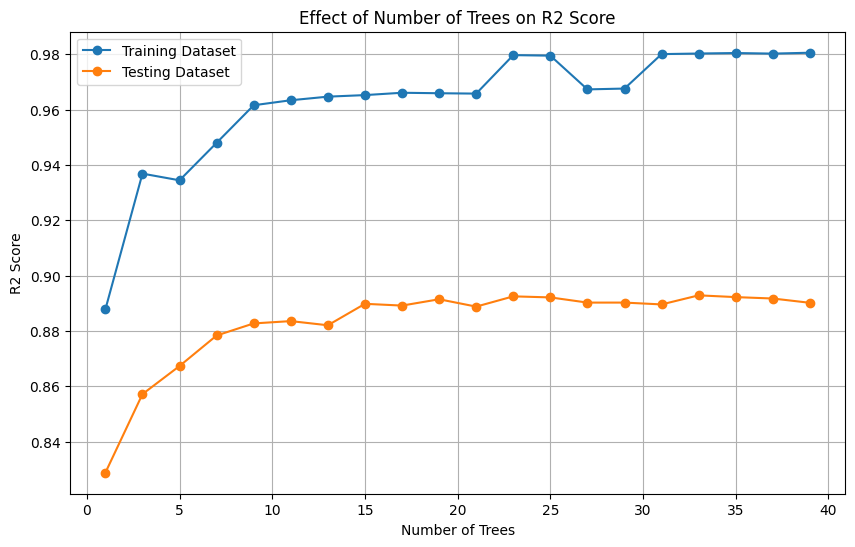

In [10]:
def ShowR2():
    plt.figure(figsize=(10, 6))
    plt.plot(plt_n, plt_r2train, marker='o', label='Training Dataset')
    plt.plot(plt_n, plt_r2test, marker='o', label='Testing Dataset')
    plt.title('Effect of Number of Trees on R2 Score')
    plt.xlabel('Number of Trees')
    plt.ylabel('R2 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

ShowR2()

### Feature Importances Diagram

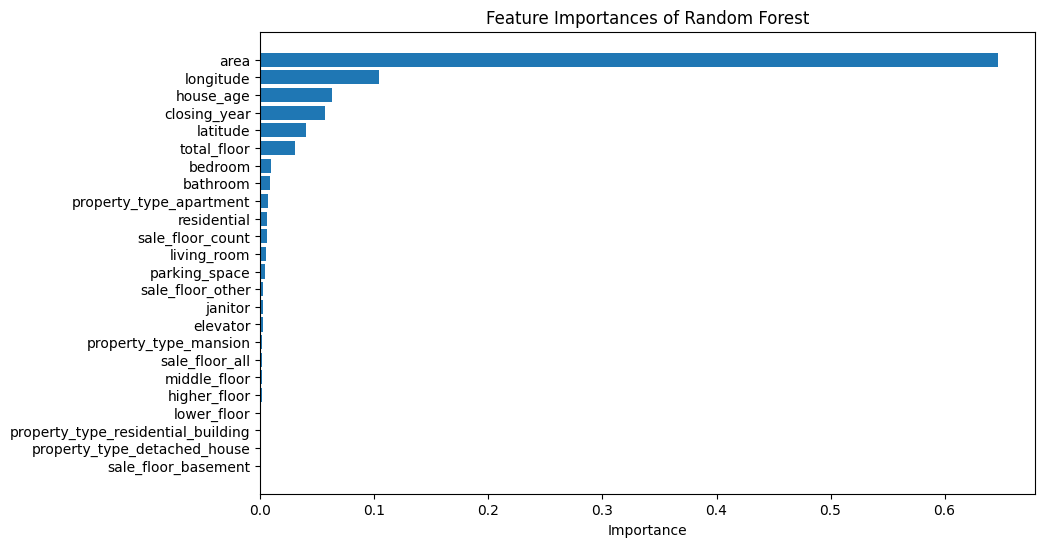

In [11]:
def ShowFeatureImportances(df):
    feature_names = df.columns[:-1]
    feature_importances = Regressor.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importances of Random Forest')
    plt.show()


ShowFeatureImportances(train_df)